

---

# 0) Notebook outline

1. Environment check & installs
2. Config (paths + hyperparams)
3. Quick data sanity (shape, spacing, histogram)
4. Preprocessing (reorient → resample → normalize)
5. Class weights (from the mask)
6. Dataset & patch sampler (class-balanced)
7. Model / loss / optimizer
8. Train loop + lightweight logging
9. Full-volume inference (sliding window)
10. Post-processing (largest CC per class)
11. Metrics (per-class Dice)
12. Visualization (overlay slices)
13. Export artifacts (ckpt, pred, config snapshot)


## 1) Environment check & installs


In [57]:
# !unzip data.zip
!zip data.zip data/*

  adding: data/egg_label.nii (deflated 97%)
  adding: data/mri_single_egg.nii (deflated 6%)
  adding: data/outputs/ (stored 0%)
  adding: data/preprocessed/ (stored 0%)


In [ ]:
# !pip install -q numpy scipy scikit-image scikit-learn pandas seaborn plotly matplotlib  notebook  nibabel SimpleITK pytest tqdm pyyaml monai

In [11]:
import os, json, math, random, time, numpy as np
import torch, nibabel as nib
from pathlib import Path
from tqdm import tqdm


# MONAI transforms (data preprocessing and augmentation for medical images)
import monai

from monai.transforms import (
    Compose,                        # Compose multiple transforms together
    LoadImaged,                     # Load image and metadata dictionary
    EnsureChannelFirstd,            # Ensure image tensor has channels as first dimension
    Orientationd,                   # Reorient image to a canonical orientation
    Spacingd,                       # Resample images to given voxel spacing
    ScaleIntensityRangePercentilesd,# Intensity scaling based on percentile range
    NormalizeIntensityd,            # Normalize image intensities
    ToTensord,                      # Convert numpy arrays to PyTorch tensors
    RandFlipd,                      # Randomly flip images along spatial axes
    RandRotate90d,                  # Randomly rotate images by 90 degrees
    RandAffined,                    # Random affine transformations (rotate, scale, shear, etc.)
    RandGaussianNoised,             # Add random Gaussian noise
    RandAdjustContrastd,            # Randomly adjust image contrast
    RandCropByLabelClassesd,        # Random crop patches around label classes
    AsDiscreted,                    # Convert predictions to discrete labels
    KeepLargestConnectedComponentd, # Keep only the largest connected region (e.g., tumor mask)
    SaveImaged,                     # Save transformed images to disk
    DivisiblePadd,                  # Pad image size to be divisible by a given factor
    EnsureTyped                     # Ensure data types are consistent (torch.Tensor, MetaTensor, etc.)
)

# MONAI data structures and utilities
from monai.data.meta_tensor import MetaTensor        # Tensor with metadata support
from monai.data import Dataset, DataLoader, NibabelWriter  # Dataset/DataLoader classes, NIfTI writer

# MONAI MODELS
from monai.networks.nets import UNet  # U-Net architecture for medical image segmentation

# MONAI losses
from monai.losses import DiceCELoss, DiceLoss  # Loss functions for segmentation tasks

# MONAI inference utilities
from monai.inferers import sliding_window_inference  # Inference method for large 3D images

In [12]:
print("Torch:", torch.__version__, "CUDA:", torch.cuda.is_available(),
      "MONAI:", monai.__version__)
device = "cuda" if torch.cuda.is_available() else "cpu"


Torch: 2.6.0+cu124 CUDA: False MONAI: 1.5.0


## 2) Config (edit paths only)


In [18]:
IMG_PATH = "data/mri_single_egg.nii"
LBL_PATH = "data/egg_label.nii"

OUT_DIR = Path("data/outputs"); OUT_DIR.mkdir(parents=True, exist_ok=True)
PP_DIR  = Path("data/preprocessed"); PP_DIR.mkdir(parents=True, exist_ok=True)

CFG = {
    "labels": {"bg":0, "white":1, "yolk":2, "air":3},
    "preprocess": {
        "do_n4": False,
        "spacing": (1.0, 1.0, 1.0),
        "orientation": "RAS",
        "percentiles": (0.5, 99.5),
        "zscore_nonzero": True
    },
    "train": {
        # Remove these if not using patch training:
        # "roi": (128,128,128),
        # "samples_per_iter": 12,
        # "crop_ratios": [0.2, 0.4, 0.3, 0.1],

        "batch_size": 2,
        "max_iters": 2000,        # increase for better training
        "lr": 2e-4,
        "weight_decay": 1e-5,
        "channels": (16,32,64,128,256),
        "strides":  (2,2,2,2),
        "include_bg_in_dice": False,
        "ce_weight_cap": (0.25, 4.0)
    },
    "infer": {"overlap": 0.5, "sw_batch": 2},  # only used with SlidingWindowInferer
    "seed": 42
}


# deterministic-ish
torch.manual_seed(CFG["seed"]); np.random.seed(CFG["seed"]); random.seed(CFG["seed"])
if device == "cuda":
    torch.cuda.manual_seed_all(CFG["seed"])


## 3) Quick data sanity


In [19]:
img_nii = nib.load(IMG_PATH); lbl_nii = nib.load(LBL_PATH)
img = img_nii.get_fdata()
lbl = lbl_nii.get_fdata().astype(np.int64)

print("Image shape:", img.shape, "Label shape:", lbl.shape)
print("Unique labels:", np.unique(lbl))
print("Voxel spacing from header (if present):", img_nii.header.get_zooms())
assert img.shape == lbl.shape, "Image/label shape mismatch."


Image shape: (36, 45, 80) Label shape: (36, 45, 80)
Unique labels: [0 1 2 3]
Voxel spacing from header (if present): (np.float32(1.3333334), np.float32(1.0), np.float32(1.0))


## 4) Preprocessing (reorient → resample → normalize)


In [20]:
preproc = Compose([
    LoadImaged(keys=["image", "label"]),

    # Ensure channel-first format (C, D, H, W) instead of (D, H, W, C)
    EnsureChannelFirstd(keys=["image", "label"]),

    # Reorient to a consistent anatomical orientation (e.g., RAS)
    Orientationd(keys=["image", "label"], axcodes=CFG["preprocess"]["orientation"]),

    # Resample to target voxel spacing
    #   - bilinear for continuous image data
    #   - nearest-neighbor for discrete label masks
    Spacingd(
        keys=["image", "label"],
        pixdim=CFG["preprocess"]["spacing"],
        mode=("bilinear", "nearest")
    ),

    # Intensity normalization using percentile clipping
    # Maps voxel values between [0,1] based on given percentiles
    ScaleIntensityRangePercentilesd(
        keys=["image"],
        lower=CFG["preprocess"]["percentiles"][0],
        upper=CFG["preprocess"]["percentiles"][1],
        b_min=0.0, b_max=1.0, clip=True
    ),

    # Normalize intensities (per channel, non-background voxels only)
    NormalizeIntensityd(keys=["image"], nonzero=True, channel_wise=True),

    # Convert numpy arrays to torch tensors
    ToTensord(keys=["image", "label"])
])

# Apply transforms to input dictionary
data_dict = {"image": IMG_PATH, "label": LBL_PATH}
ppd = preproc(data_dict)

# Extract preprocessed tensors
img_pp = ppd["image"]  # image: shape (1, D, H, W)
lbl_pp = ppd["label"].long()  # label: shape (1, D, H, W)

print("Preprocessed shapes:", img_pp.shape, lbl_pp.shape)

# Save preprocessed NIfTI volumes (with spatial metadata preserved)
saver = SaveImaged(
    keys=["image", "label"],
    output_dir=str(PP_DIR),
    output_postfix="pp",
    output_ext=".nii.gz",
    separate_folder=False
)
_ = saver(ppd)

print("Wrote preprocessed NIfTI to", PP_DIR)

Preprocessed shapes: torch.Size([1, 48, 45, 80]) torch.Size([1, 48, 45, 80])
2025-08-18 15:50:59,652 INFO image_writer.py:197 - writing: data/preprocessed/mri_single_egg_pp.nii.gz
2025-08-18 15:50:59,703 INFO image_writer.py:197 - writing: data/preprocessed/egg_label_pp.nii.gz
Wrote preprocessed NIfTI to data/preprocessed


## 5) Class weights (from the mask) :
Balancing class importance for training a segmentation model, ensuring rare structures like yolk or air are not ignored compared to abundant background voxels.


In [21]:
def compute_ce_weights_from_label(lbl_path, labels_map, clamp=(0.25,4.0), boost_air=True):
    lab = nib.load(lbl_path).get_fdata().astype(np.int64)

    # Define class IDs
    classes = [labels_map["bg"], labels_map["white"], labels_map["yolk"], labels_map["air"]]

    # Count number of voxels belonging to each class
    counts = np.array([(lab == c).sum() for c in classes], dtype=np.float64)

    # Avoid division by zero (ensure min count = 1)
    counts = np.maximum(counts, 1.0)


    # Compute relative frequency of each class
    freq = counts / counts.sum()

    # Inverse frequency weighting (rare classes get higher weight)
    w = 1.0 / freq


    # Normalize so that mean weight = 1
    w = w / w.mean()

    # --- Adjustments ---

    # De-emphasize background: making it less dominating
    w[0] = min(w[0], 0.5 * w[1:].mean())

    # Optionally boost "air" class (small pockets)
    if boost_air:
        w[3] *= 1.25

    # Clamp weights within reasonable range
    w = np.clip(w, clamp[0], clamp[1])

    return w


ce_weights = compute_ce_weights_from_label(str(PP_DIR/"egg_label_pp.nii.gz"), CFG["labels"],
                                           clamp=CFG["train"]["ce_weight_cap"])
ce_weights


array([0.25, 0.25, 0.25, 4.  ])

## 6) Dataset & patch sampler (class-balanced) :
Let's make a dataloader that loads MRI volumes,
- standardizes their orientation/spacing/intensities,
- apply light data augmentations
- Prepares them as PyTorch tensors for segmentation training.


In [22]:
train_transforms = Compose([
    LoadImaged(keys=["image","label"]),

    # Ensure channel-first format: (C, D, H, W)
    EnsureChannelFirstd(keys=["image","label"]),

    # Reorient to a standard anatomical orientation (e.g., RAS)
    Orientationd(keys=["image","label"], axcodes=CFG["preprocess"]["orientation"]),

    # Resample to target voxel spacing
    # - bilinear for continuous image data
    # - nearest-neighbor for discrete label masks
    Spacingd(
        keys=["image","label"],
        pixdim=CFG["preprocess"]["spacing"],
        mode=("bilinear","nearest")
    ),

    # Scale intensities to [0,1] using 0.5–99.5 percentile clipping
    ScaleIntensityRangePercentilesd(
        keys=["image"],
        lower=0.5, upper=99.5,
        b_min=0., b_max=1.,
        clip=True
    ),

    # Z-score normalize intensities (per channel, ignoring background)
    NormalizeIntensityd(keys=["image"], nonzero=True, channel_wise=True),

    # Pad so dimensions are divisible by 16 (useful for UNet downsampling/upsampling)
    DivisiblePadd(keys=["image","label"], k=16),

    # --- AUGMENTATIONS ---

    # Random flips along X/Y/Z axes (each with 50% chance)
    RandFlipd(keys=["image","label"], prob=0.5, spatial_axis=0),
    RandFlipd(keys=["image","label"], prob=0.5, spatial_axis=1),
    RandFlipd(keys=["image","label"], prob=0.5, spatial_axis=2),

    # Random 90° rotations (20% chance, up to 270°)
    RandRotate90d(keys=["image","label"], prob=0.2, max_k=3),

    # Random affine (rotation ~±11°, scaling ±10%)
    # Bilinear interpolation for image, nearest-neighbor for label
    RandAffined(
        keys=["image","label"],
        prob=0.2,
        rotate_range=(0.2,0.2,0.2),
        scale_range=(0.1,0.1,0.1),
        mode=("bilinear","nearest")
    ),

    # Add Gaussian noise to the image (15% chance)
    RandGaussianNoised(keys=["image"], prob=0.15, mean=0.0, std=0.02),

    # Random contrast adjustment (gamma correction between 0.7–1.3)
    RandAdjustContrastd(keys=["image"], prob=0.15, gamma=(0.7,1.3)),

    # Convert numpy arrays → torch tensors
    ToTensord(keys=["image","label"])
])


train_ds = Dataset(
    data=[{"image": str(PP_DIR/"mri_single_egg_pp.nii.gz"), "label": str(PP_DIR/"egg_label_pp.nii.gz")}],
    transform=train_transforms
)
train_loader = DataLoader(train_ds, batch_size=CFG["train"]["batch_size"], shuffle=True,
                          num_workers=2, pin_memory=(device=="cuda"))

# Peek at one batch (full volume)
batch = next(iter(train_loader))
print(batch["image"].shape, batch["label"].shape)


torch.Size([1, 1, 48, 48, 80]) torch.Size([1, 1, 48, 48, 80])


## 7) Model / loss / optimizer :

Let's define the 3D U-Net model.

### Loss functions :

- Dice loss
  - Measures overlap between prediction and ground truth.

- Cross-entropy (CE) loss
  - Standard classification loss. Encourages correct voxel-wise class probabilities.


### Let's make a Combined loss (compute_loss) :
- Uses a weighted sum: 0.7 * Dice + 0.3 * CE.

- Why combine?
  - Dice optimizes global overlap (good for segmentation quality).
  - Cross-entropy optimizes local, voxel-level classification.
  - We will get stable training (from CE) + better shape/overlap learning (from Dice).
  


In [23]:
model = UNet(
    spatial_dims=3,       # 3D U-Net (for volumetric data)
    in_channels=1,        # single-channel input (e.g., grayscale MRI)
    out_channels=4,       # number of segmentation classes (bg, white, yolk, air)
    channels=CFG["train"]["channels"],  # number of feature maps at each level
    strides=CFG["train"]["strides"],    # downsampling strides per level
    num_res_units=2       # number of residual units per stage (adds depth)
).to(device)              # move model to GPU/CPU

dice_loss = DiceLoss(
    include_background=CFG["train"]["include_bg_in_dice"],  # optionally exclude bg from Dice
    to_onehot_y=True,      # convert target labels to one-hot encoding
    softmax=True,          # apply softmax on logits before Dice
    squared_pred=True      # use squared predictions in denominator (stabilizes training)
)

# Cross-entropy loss: penalizes misclassifications
# Weighted by class-balancing weights (computed earlier)
ce_loss = torch.nn.CrossEntropyLoss(
    weight=torch.tensor(ce_weights, dtype=torch.float32, device=device)
)

# Combined loss function (weighted sum of Dice + CE)
def compute_loss(logits, targets):
    # targets shape: (B, 1, D, H, W), need squeeze for CE
    return 0.7 * dice_loss(logits, targets) + \
           0.3 * ce_loss(logits, targets[:,0].long())

# --- OPTIMIZER ---
# AdamW: Adam with decoupled weight decay (better regularization)
opt = torch.optim.AdamW(
    model.parameters(),
    lr=CFG["train"]["lr"],                  # learning rate
    weight_decay=CFG["train"]["weight_decay"]  # L2 regularization
)

# --- MIXED PRECISION TRAINING (optional, only if GPU) ---
# GradScaler: scales gradients to avoid underflow in FP16
scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))


/tmp/ipython-input-4056924812.py:41: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))


## 8) Train loop + logging


In [24]:
model.train()
it = 0
loss_hist = []

# Initialize progress bar
pbar = tqdm(total=CFG["train"]["max_iters"], desc="Training Progress")

# Training loop
while it < CFG["train"]["max_iters"]:
    # Iterate over the training data loader
    for batch in train_loader:
        # Move data to the appropriate device
        img = batch["image"].to(device)            # (B,1,D,H,W)
        y   = batch["label"].long().to(device)     # (B,1,D,H,W) ints in {0..3}

        # Enable automatic mixed precision (AMP) for potentially faster training
        with torch.cuda.amp.autocast(enabled=(device=="cuda")):
            # Forward pass: compute model output (logits)
            logits = model(img)                    # (B,4,D,H,W)
            # Compute the loss
            loss = compute_loss(logits, y)

        # Backward pass and optimizer step with gradient scaling (for AMP)
        scaler.scale(loss).backward()
        scaler.step(opt); scaler.update(); opt.zero_grad(set_to_none=True)

        # Update iteration count and loss history
        it += 1
        loss_hist.append(float(loss.item()))

        # Update progress bar every 10 iterations
        if it % 100 == 0:
            pbar.update(100)
            pbar.set_postfix(loss=f"{loss.item():.4f}")


        # Stop training if max iterations are reached
        if it >= CFG["train"]["max_iters"]:
            break

# Close the progress bar
pbar.close()

# Save the trained model checkpoint
CKPT_PATH = OUT_DIR/"ckpts"; CKPT_PATH.mkdir(parents=True, exist_ok=True)
torch.save(model.state_dict(), CKPT_PATH/"unet_egg_single_overfit.pt")
print("Saved:", CKPT_PATH/"unet_egg_single_overfit.pt")

Training Progress:   0%|          | 0/2000 [00:00<?, ?it/s]/tmp/ipython-input-3125697638.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Training Progress: 100%|██████████| 2000/2000 [49:52<00:00,  1.50s/it, loss=0.0957]

Saved: data/outputs/ckpts/unet_egg_single_overfit.pt


## 9) Full-volume inference (sliding window)
Let's create a MONAI inference pipeline:
-  Standardizes an input 3D image, run a trained 3D U-Net to get class predictions,
- Convert logits to a discrete label volume
- Save the result as a NIfTI while preserving correct spatial geometry (affine/metadata).

In [39]:
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Orientationd, Spacingd,
    ScaleIntensityRangePercentilesd, NormalizeIntensityd, DivisiblePadd,
    EnsureTyped
)
from monai.data.meta_tensor import MetaTensor

infer_transforms = Compose([
    LoadImaged(keys=["image"]),
    EnsureChannelFirstd(keys=["image"]),
    Orientationd(keys=["image"], axcodes=CFG["preprocess"]["orientation"]),
    Spacingd(keys=["image"], pixdim=CFG["preprocess"]["spacing"], mode=("bilinear",)),
    ScaleIntensityRangePercentilesd(
        keys=["image"], lower=0.5, upper=99.5, b_min=0., b_max=1., clip=True
    ),
    NormalizeIntensityd(keys=["image"], nonzero=True, channel_wise=True),
    DivisiblePadd(keys=["image"], k=16),
    EnsureTyped(keys=["image"], track_meta=True),  # keeps MetaTensor w/ meta + affine
])

model.eval()
with torch.no_grad():
    # Apply transforms to image file
    batch = infer_transforms({"image": str(PP_DIR / "mri_single_egg_pp.nii.gz")})

    # MetaTensor containing data + metadata
    img: MetaTensor = batch["image"]  # shape: (C, D, H, W)

    # Build input tensor (B, C, D, H, W)
    x = img.unsqueeze(0).to(device)

    # Forward pass
    logits = model(x)

    # Softmax -> argmax -> numpy (D, H, W), uint8
    pred = (
        logits.softmax(dim=1)
        .argmax(dim=1)
        .cpu()
        .numpy()
        .astype(np.uint8)[0]
    )

# COMMON AFFINE / META (from MetaTensor)

# Prefer the MetaTensor's affine; fall back to stored meta or identity
aff = getattr(img, "affine", None)
if aff is None:
    aff = img.meta.get("affine", img.meta.get("original_affine", np.eye(4)))


2025-08-18 17:07:41,858 INFO image_writer.py:197 - writing: data/outputs/preds/pred.nii.gz
Saved raw prediction -> data/outputs/preds/pred.nii.gz
2025-08-18 17:07:41,960 INFO image_writer.py:197 - writing: data/outputs/preds/pred_pp.nii.gz
Saved postprocessed prediction -> data/outputs/preds/pred_pp.nii.gz


In [ ]:

# SAVE RAW PREDICTION

out_dir = OUT_DIR / "preds"
out_dir.mkdir(parents=True, exist_ok=True)

writer = NibabelWriter()
pred_np = np.expand_dims(pred, 0)  # add channel -> (C, D, H, W)
writer.set_data_array(pred_np, channel_dim=0)
writer.set_metadata({
    "affine": aff,
    "original_affine": img.meta.get("original_affine", aff),
})
raw_path = out_dir / "pred.nii.gz"
writer.write(str(raw_path), verbose=True)
print("Saved raw prediction ->", raw_path)


## 10) Post-processing (largest CC per class)


In [55]:

post = Compose([
    AsDiscreted(keys=["pred"], to_onehot=4),
    KeepLargestConnectedComponentd(keys=["pred"], independent=True, connectivity=3),
    AsDiscreted(keys=["pred"], argmax=True),
])

pred_pp = post({"pred": torch.from_numpy(pred).unsqueeze(0)})["pred"]
pred_pp = pred_pp.numpy().astype(np.uint8)[0]  # (D, H, W)

writer = NibabelWriter()
pred_pp_np = np.expand_dims(pred_pp, 0)  # (C, D, H, W)
writer.set_data_array(pred_pp_np, channel_dim=0)
writer.set_metadata({
    "affine": aff,
    "original_affine": img.meta.get("original_affine", aff),
})
pp_path = out_dir / "pred_pp.nii.gz"
writer.write(str(pp_path), verbose=True)
print("Saved postprocessed prediction ->", pp_path)


2025-08-18 17:59:36,478 INFO image_writer.py:197 - writing: data/outputs/preds/pred_pp.nii.gz
Saved postprocessed prediction -> data/outputs/preds/pred_pp.nii.gz


## Undo Preprocessing :
Let's undo preprocessing transforms on the model’s output, so the segmentation prediction matches the original image’s orientation, spacing, and shape.

In [40]:
from monai.transforms import Invertd, AsDiscreted

# after you compute logits -> pred_torch (C=1 or already argmaxed)
pred_torch = logits.argmax(dim=1).cpu()  # (1, D, H, W) labels
data = {"image": batch["image"], "pred": pred_torch}

post_trans = Invertd(
    keys="pred",
    transform=infer_transforms,
    orig_keys="image",
    meta_keys="pred_meta_dict",
    orig_meta_keys="image_meta_dict",
    meta_key_postfix="meta_dict",
    nearest_interp=True,  # for labels
    to_tensor=True,
)
data = post_trans(data)
pred_unpadded = data["pred"].squeeze(0).numpy().astype(np.uint8)  # (D,H,W)



## 11) Metrics (per-class Dice)
Let's evaluate segmentation quality by computing the Dice coefficient per class (white, yolk, air), comparing the model’s predictions (pred_unpadded) against the ground truth NIfTI labels.


In [41]:
gt = nib.load(PP_DIR/"egg_label_pp.nii.gz").get_fdata().astype(np.uint8)
def dice_per_class(y_true, y_pred, cls):
    t = (y_true==cls).astype(np.uint8); p = (y_pred==cls).astype(np.uint8)
    inter = (t & p).sum()
    denom = t.sum() + p.sum()
    return (2*inter)/(denom+1e-8)

classes = [CFG["labels"]["white"], CFG["labels"]["yolk"], CFG["labels"]["air"]]
dice_scores = { "white": dice_per_class(gt, pred_unpadded, CFG["labels"]["white"]),
                "yolk":  dice_per_class(gt, pred_unpadded, CFG["labels"]["yolk"]),
                "air":   dice_per_class(gt, pred_unpadded, CFG["labels"]["air"]) }
dice_scores


{'white': np.float64(0.9833714721581575),
 'yolk': np.float64(0.9808054498094609),
 'air': np.float64(0.9941812136243211)}

## 12) Visualization (overlay slices)


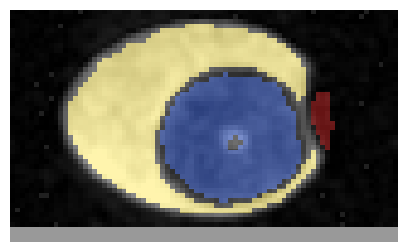

In [56]:
import matplotlib.pyplot as plt

def show_slice(vol, msk=None, z=None):
    D = vol.shape[0]
    z = D//2 if z is None else max(0, min(D-1, z))
    v = vol[z]
    plt.figure(figsize=(5,5)); plt.imshow(v, cmap="gray")
    if msk is not None:
        # simple colors: white=blue(1), yolk=yellow(2), air=red(3)
        overlay = np.zeros((*msk[z].shape, 3), dtype=float)
        overlay[msk[z]==1] = [0.2,0.4,1.0]
        overlay[msk[z]==2] = [1.0,0.9,0.2]
        overlay[msk[z]==3] = [1.0,0.2,0.2]
        plt.imshow(overlay, alpha=0.4)
    plt.axis('off'); plt.show()

# Load preprocessed arrays for viewing
img_pp_np = nib.load(PP_DIR/"mri_single_egg_pp.nii.gz").get_fdata().astype(np.float32)
pred_pp_np = nib.load(pp_path).get_fdata().astype(np.uint8)

show_slice(img_pp_np, pred_pp_np, z=img_pp_np.shape[0]//2)


## 13) Export artifacts (ckpt, pred, config snapshot) :
Let's save the trained model checkpoint, the prediction files, and a snapshot of the configuration and metrics.


In [52]:

# Save config + weights + metrics so the future CLI can pick them up verbatim
(OUT_DIR / "ckpts").mkdir(exist_ok=True, parents=True)
(OUT_DIR / "preds").mkdir(exist_ok=True, parents=True)
with open(OUT_DIR / "config_snapshot.json", "w") as f:
    json.dump(CFG, f, indent=2)

# Add the total segmented volume to the metrics dictionary
metrics = {"dice": dice_scores, "total_segmented_volume_mm3": total_segmented_volume_mm3}
with open(OUT_DIR / "metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

print("Saved config_snapshot.json and metrics.json in", OUT_DIR)

Saved config_snapshot.json and metrics.json in data/outputs


# Compare with the GT volume
Calculate the volumes of the egg yolk, egg white, and air cell from the segmentation mask in "pred_pp.nii.gz". The ground truth total egg volume is 60 mL.

## Load the postprocessed segmentation mask

Load the `pred_pp.nii.gz` file which contains the segmentation of the different egg compartments.


In [46]:

# Load the postprocessed prediction NIfTI file
pred_pp_nii = nib.load("data/outputs/preds/pred_pp.nii.gz")

# Get the image data as a NumPy array and ensure the data type is uint8
pred_pp_np = pred_pp_nii.get_fdata().astype(np.uint8)

print("Loaded segmentation mask with shape:", pred_pp_np.shape, "and dtype:", pred_pp_np.dtype)

Loaded segmentation mask with shape: (48, 48, 80) and dtype: uint8


## Get voxel dimensions

Retrieve the voxel dimensions (spacing) from the NIfTI file header.

In [48]:
# Get the voxel dimensions (spacing) from the NIfTI header
voxel_dims = pred_pp_nii.header.get_zooms()

print("Voxel dimensions (x, y, z):", voxel_dims)

Voxel dimensions (x, y, z): (np.float32(1.0), np.float32(1.0), np.float32(1.0))


## Calculate compartment volumes

For each compartment (egg yolk, egg white, air cell), count the number of voxels assigned to that class in the segmentation mask and multiply by the volume of a single voxel.

In [49]:
# Calculate the volume of a single voxel in cubic millimeters (mm^3)
voxel_volume_mm3 = voxel_dims[0] * voxel_dims[1] * voxel_dims[2]

# Get the label values for each compartment from the configuration
label_white = CFG["labels"]["white"]
label_yolk = CFG["labels"]["yolk"]
label_air = CFG["labels"]["air"]

# Count the number of voxels for each compartment
white_voxel_count = np.sum(pred_pp_np == label_white)
yolk_voxel_count = np.sum(pred_pp_np == label_yolk)
air_voxel_count = np.sum(pred_pp_np == label_air)

# Calculate the volume of each compartment in mm^3
white_volume_mm3 = white_voxel_count * voxel_volume_mm3
yolk_volume_mm3 = yolk_voxel_count * voxel_volume_mm3
air_volume_mm3 = air_voxel_count * voxel_volume_mm3

print(f"Egg white volume: {white_volume_mm3:.2f} mm³")
print(f"Egg yolk volume: {yolk_volume_mm3:.2f} mm³")
print(f"Air cell volume: {air_volume_mm3:.2f} mm³")

Egg white volume: 9872.00 mm³
Egg yolk volume: 25093.00 mm³
Air cell volume: 598.00 mm³


## Calculate total volume from segmentation

Sum the volumes of all compartments (egg white, egg yolk, and air cell) to get the total volume as calculated from the segmentation.


In [50]:
# Calculate the total volume from the segmentation by summing the individual compartment volumes
total_segmented_volume_mm3 = white_volume_mm3 + yolk_volume_mm3 + air_volume_mm3

print(f"Total segmented volume: {total_segmented_volume_mm3:.2f} mm³")

Total segmented volume: 35563.00 mm³


## Compare volumes and display results

Let's Compare the calculated compartment volumes and the total segmented volume with the provided ground truth total volume (60 mL) and display the results.

In [54]:
# Ground truth total egg volume in mL
ground_truth_total_volume_mL = 60

# Convert ground truth volume to mm^3 (1 mL = 1 cm^3 = 1000 mm^3)
ground_truth_total_volume_mm3 = ground_truth_total_volume_mL * 1000

print("--- Volume Comparison ---")
print(f"Ground Truth Total Egg Volume: {ground_truth_total_volume_mL} mL ({ground_truth_total_volume_mm3:.2f} mm³)")
print(f"Total Segmented Volume: {total_segmented_volume_mm3:.2f} mm³")

# Calculate the difference and percentage difference
volume_difference_mm3 = total_segmented_volume_mm3 - ground_truth_total_volume_mm3
percentage_difference = (volume_difference_mm3 / ground_truth_total_volume_mm3) * 100 if ground_truth_total_volume_mm3 != 0 else 0

print(f"Difference (Segmented - Ground Truth): {volume_difference_mm3:.2f} mm³")
print(f"Percentage Difference: {percentage_difference:.2f}%")

print("\n--- Compartment Volumes ---")
print(f"Egg white volume: {white_volume_mm3:.2f} mm³")
print(f"Egg yolk volume: {yolk_volume_mm3:.2f} mm³")
print(f"Air cell volume: {air_volume_mm3:.2f} mm³")

--- Volume Comparison ---
Ground Truth Total Egg Volume: 60 mL (60000.00 mm³)
Total Segmented Volume: 35563.00 mm³
Difference (Segmented - Ground Truth): -24437.00 mm³
Percentage Difference: -40.73%

--- Compartment Volumes ---
Egg white volume: 9872.00 mm³
Egg yolk volume: 25093.00 mm³
Air cell volume: 598.00 mm³
